# DAML 08 - kmeans

Michal Grochmal <michal.grochmal@city.ac.uk>

The **expectation-maximization** (E-M) algorithm comes often in machine learning.
It consists of the repetition of E-steps (expectation) and M-steps (maximization) until
the algorithm converges to a point where more steps would not change the solution.
In other words at each step some **fitness function** comes closer to an optimal value.
In general the algorithm can look as follows:

1.  Assign data to the expected solution from previous step (E-step)
2.  Change the solution so that the current state of data maximizes a fitness function (M-step)
3.  Repeat until convergence

The `kmeans` algorithm is a clear implementation of expectation-maximization,
the algorithm works as follows:

1.  Assign random cluster centers
2.  (E-step) assign data points, according to some distance measure, to the closest cluster center
3.  (M-step) create new cluster centers from the mean of currently assigned data points

Note that the above requires some form of **distance measure**, and that the *fitness function*
is the minimization of all the distances.  Let's do the initial imports and dive into `kmeans`
with an example.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
from scipy.stats import mode
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score, f1_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline

## Limitations

One limitation of `kmeans` that's apparent on first sight is that we need to know
a-priori the number of clusters we want to assign the data to.  Although **cluster inertia**
measures across several amounts of clusters or a handful of statistical techniques 
(e.g. silhouette analysis) exist to estimate a good number of clusters, these are far from perfect.
Previous knowledge, possibly aided by dimensionality reduction is often needed to find a good
number of clusters.

The expectation-maximization algorithm requires stochastic initialization and, given a
bad initial start, may find a local maximum instead of a global maximum.  In other words
badly initialized `kmeans` can cluster badly.  In practice E-M algorithms shall run for
several random initializations and then be evaluated.  Below the hood this is what the `sklearn`
version of `kmeans` does, it runs the model fit several times and selects the best model.
(The number of times the `kmeans` algorithm is run by `sklearn` is defined by the `n_init`
argument to the class initialization.)

`kmeans` is a linear algorithm and will only find clusters defined by linear borders.
Graph techniques such as spectral clustering or some versions of hierarchical clustering
are capable of dealing directly with non-linear clusters.  Yet another technique is to
use preprocessing with some form of manifold techniques and then cluster the linearized
data with (possibly a variant of) `kmeans`.

## Handwritten Digits

Without knowing of any labels `kmeans` can deal with quite complex problems.
We saw that the digits dataset is not particularly easy since it contains
non-linear relationships.  Let's see what `kmeans` can take out of that data.

In [2]:
digits = load_digits()
digits.data.shape

(1797, 64)

In [3]:
kmeans = KMeans(n_clusters=10)  # we know the number of clusters
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

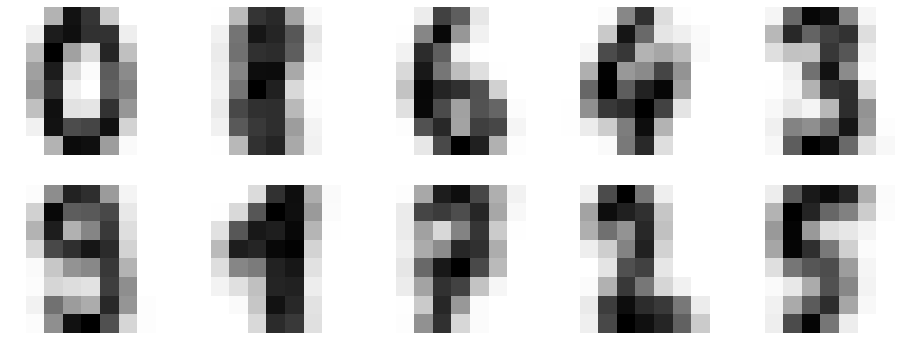

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(16, 6), subplot_kw={'xticks':[], 'yticks':[]})
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for ax, center in zip(axes.flat, centers):
    ax.imshow(center, cmap='binary')

In [5]:
clusters.shape, np.unique(clusters)

((1797,), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32))

In [6]:
label_map = {}
for i in range(10):
    label_map[i] = mode(digits.target[clusters == i])[0]
label_map

{0: array([0]),
 1: array([8]),
 2: array([6]),
 3: array([4]),
 4: array([3]),
 5: array([9]),
 6: array([1]),
 7: array([7]),
 8: array([2]),
 9: array([5])}

In [7]:
labels = np.zeros_like(clusters)
for k, v in label_map.items():
    labels[clusters == k] = v
labels.shape

(1797,)

Default `kmeans` scoring is by **cluster inertia**, the sum of all distances form points
to its cluster centre.  This allows to compare two `kmeans` runs against each other.
Notably, `sklearn` performs `kmeans` several times and then compares the inertia.
But this is not a good measure to compare `kmeans` between datasets or against
other models.

In [8]:
accuracy_score(digits.target, labels), f1_score(digits.target, labels, average='weighted')

(0.79243183082915969, 0.78875967910787026)

For an algorithm that only knew that there are 10 digits in the data but had
no idea how they look like that is a pretty amazing score.  Let's look
at what got misclassified the most.

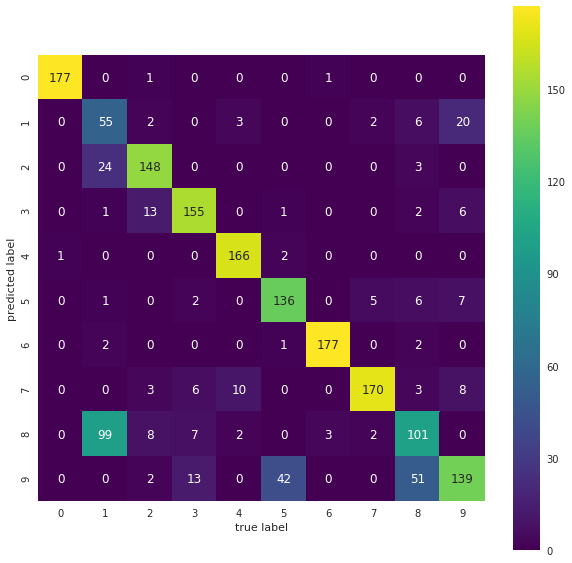

In [9]:
mat = confusion_matrix(digits.target, labels)
fig = plt.figure(figsize=(10, 10))
ax = sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap='viridis',
                 xticklabels=digits.target_names, yticklabels=digits.target_names)
ax.set(xlabel='true label', ylabel='predicted label');

## Extra: Distance Measures

We have only dealt with *euclidean distances* but that is not the only distance measure available.
In machine learning algorithm and in literature you will often find mention of *L-norms*.
An *L-norm* (also called $L^p$ space) often written as L1, L2, $\|\cdot\|_1$ or $\|\cdot\|_2$
is a notation of the use of distance.  The most important one being L2 ($\|\cdot\|_2$), the
euclidean distance.  The L-norm is defined, for a vector of $i$ components, as:

$$\|x\|_k = \left( \sum_{i=0}^{N} \lvert x_i \rvert ^k \right)^{\frac{1}{k}}$$

Therefore $\|x\|_2$ is our well known

$$\|x\|_2 = \sqrt{\sum_{i=0}^{N} x_i^2}$$

The sum of absolutes, or $\|x\|_1$ turns to be resistant against outliers,
and is sometimes preferred as a distance measure

$$\|x\|_1 = \sum_{i=0}^{N} \lvert x_i \rvert$$